In [1]:
import pandas as pd
import numpy as np
import missingno as msno
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# read in data
data = pd.read_csv('data/train.csv')

# read in test data
test = pd.read_csv('data/test.csv')

In [3]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
missing_values = data.isnull().mean()
missing_values

PassengerId     0.000000
HomePlanet      0.023122
CryoSleep       0.024963
Cabin           0.022892
Destination     0.020936
Age             0.020591
VIP             0.023352
RoomService     0.020821
FoodCourt       0.021051
ShoppingMall    0.023927
Spa             0.021051
VRDeck          0.021627
Name            0.023007
Transported     0.000000
dtype: float64

% of rows with missing values: 24.01%


<AxesSubplot: >

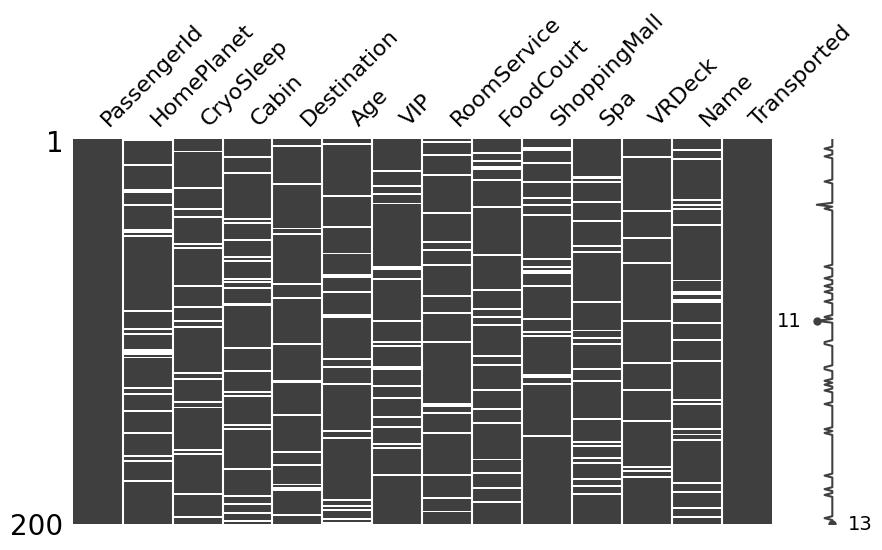

In [6]:
# get rows with missing values, sample 200 of them, visualize them with missingno
missing_train = data[data.isnull().any(axis=1)]
print(f'% of rows with missing values: {len(missing_train)/len(data)*100:.2f}%')
msno.matrix(missing_train.sample(200), figsize=(10, 5))

In [7]:
# Initialize an empty dictionary to hold p-values
p_values = {}

# Loop over columns
for column in data.columns:
    if data[column].isnull().any():  # if the column has missing values
        # Compare distributions of numerical columns in rows where 'column' is missing vs not missing
        p_values[column] = {}
        for num_column in data.select_dtypes(include=[np.number]).columns:
            if num_column != column:  # avoid comparing a column with itself
                # Perform a Kolmogorov-Smirnov test (a 2-sample test to compare distributions)
                _, p_value = ks_2samp(data.loc[data[column].isnull(), num_column].dropna(),
                                      data.loc[data[column].notnull(), num_column].dropna())
                p_values[column][num_column] = p_value

# Convert dictionary to DataFrame
p_values = pd.DataFrame(p_values)
p_values

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
Age,0.910156,0.361841,0.915561,0.165507,NaN,0.434924,0.074629,0.414203,0.798619,0.830167,0.210945,0.507161
RoomService,0.867838,0.999468,0.975527,0.688854,0.577874,0.969110,NaN,0.999016,0.811709,0.176488,0.290025,0.928330
FoodCourt,0.748817,0.885121,0.920901,0.995295,0.853947,0.988739,0.935038,NaN,0.184462,0.578431,0.701111,0.965022
ShoppingMall,0.696107,0.641470,0.119795,0.761485,0.136680,0.534693,0.981525,0.998392,NaN,0.953773,0.638414,0.982638
Spa,0.463948,0.708913,0.686180,0.600483,0.898993,0.999962,0.611765,0.655985,0.062396,NaN,0.244178,0.985091
VRDeck,0.903086,0.835444,0.922832,0.563879,0.684721,0.842138,0.904256,0.752953,0.594020,0.999159,NaN,0.985043


In [8]:
data['Group'] = data['PassengerId'].map(lambda x: re.split("_", x)[0])
data['GroupNum'] = data['PassengerId'].map(lambda x: re.split("_", x)[1])
data.drop(['PassengerId'], inplace=True, axis=1)

test['Group'] = test['PassengerId'].map(lambda x: re.split("_", x)[0])
test['GroupNum'] = test['PassengerId'].map(lambda x: re.split("_", x)[1])
# don't drop PassengerId from test set, need it for submission

In [9]:
data['Name'] = data['Name'].str.lower()
data['FirstName'] = data['Name'].map(lambda x: re.split(' ', x)[0], na_action='ignore')
data['LastName'] = data['Name'].map(lambda x: re.split(' ', x)[1], na_action='ignore')
data.drop('Name', axis=1, inplace=True)

test['Name'] = test['Name'].str.lower()
test['FirstName'] = test['Name'].map(lambda x: re.split(' ', x)[0], na_action='ignore')
test['LastName'] = test['Name'].map(lambda x: re.split(' ', x)[1], na_action='ignore')
test.drop('Name', axis=1, inplace=True)

In [10]:
data['Deck'] = data['Cabin'].map(lambda x: re.split("/", x)[0], na_action='ignore')
data['Num'] = data['Cabin'].map(lambda x: re.split("/", x)[1], na_action='ignore')
# data['Num'] = pd.to_numeric(data['Num'], errors='coerce')
# num_mean = data['Num'].mean()
# data['Num'].fillna(num_mean, inplace=True)
data['Split'] = data['Cabin'].map(lambda x: re.split("/", x)[2], na_action='ignore')
data.drop('Cabin', axis=1, inplace=True)

test['Deck'] = test['Cabin'].map(lambda x: re.split("/", x)[0], na_action='ignore')
test['Num'] = test['Cabin'].map(lambda x: re.split("/", x)[1], na_action='ignore')
# test['Num'] = pd.to_numeric(test['Num'], errors='coerce')
# test['Num'].fillna(num_mean, inplace=True)
test['Split'] = test['Cabin'].map(lambda x: re.split("/", x)[2], na_action='ignore')
test.drop('Cabin', axis=1, inplace=True)

In [11]:
# save data
data.to_csv('data/train_cleaned_no_fillna.csv', index=False)
test.to_csv('data/test_cleaned_no_fillna.csv', index=False)

In [12]:
# first, impute the columns with missing values and have CryoSleep = True to 0 (if you are asleep, you can't spend)
missing = data.loc[((data['RoomService'].isna()) | (data['FoodCourt'].isna()) | (data['ShoppingMall'].isna())
                      | (data['Spa'].isna()) | (data['VRDeck'].isna())) & (data['CryoSleep'] == True), :]
data.loc[(data['RoomService'].isna()) & (data['CryoSleep'] == True), 'RoomService'] = 0
data.loc[(data['FoodCourt'].isna()) & (data['CryoSleep'] == True), 'FoodCourt'] = 0
data.loc[(data['ShoppingMall'].isna()) & (data['CryoSleep'] == True), 'ShoppingMall'] = 0
data.loc[(data['Spa'].isna()) & (data['CryoSleep'] == True), 'Spa'] = 0
data.loc[(data['VRDeck'].isna()) & (data['CryoSleep'] == True), 'VRDeck'] = 0

# do the same for test data
missing = test.loc[((test['RoomService'].isna()) | (test['FoodCourt'].isna()) | (test['ShoppingMall'].isna())
                      | (test['Spa'].isna()) | (test['VRDeck'].isna())) & (test['CryoSleep'] == True), :]
test.loc[(test['RoomService'].isna()) & (test['CryoSleep'] == True), 'RoomService'] = 0
test.loc[(test['FoodCourt'].isna()) & (test['CryoSleep'] == True), 'FoodCourt'] = 0
test.loc[(test['ShoppingMall'].isna()) & (test['CryoSleep'] == True), 'ShoppingMall'] = 0
test.loc[(test['Spa'].isna()) & (test['CryoSleep'] == True), 'Spa'] = 0
test.loc[(test['VRDeck'].isna()) & (test['CryoSleep'] == True), 'VRDeck'] = 0

In [18]:
temp = data.loc[data['Group'].notnull() & data['HomePlanet'].notnull(), ['Group', 'HomePlanet']]
# confirm whether each group has only one home planet
confirm = temp.groupby('Group').nunique()
confirm[confirm['HomePlanet'] > 1]

,HomePlanet
Group,


In [302]:
# passengers from the same group are from the same HomePlanet
data.loc[data['HomePlanet'].isna(), 'HomePlanet'] = data.loc[data['HomePlanet'].isna(), 'Group']
test.loc[test['HomePlanet'].isna(), 'HomePlanet'] = test.loc[test['HomePlanet'].isna(), 'Group']

In [303]:
# save data
data.to_csv('data/train_cleaned_no_fillna_imputed.csv', index=False)
test.to_csv('data/test_cleaned_no_fillna_imputed.csv', index=False)

In [304]:
# get all the columns with numerical values
numerical_cols = [cname for cname in data.columns if data[cname].dtype in ['int64', 'float64']]
print(numerical_cols)
# get all the columns with categorical values
categorical_cols = [cname for cname in data.columns if data[cname].dtype == 'object']
print(categorical_cols)

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Group', 'GroupNum', 'FirstName', 'LastName', 'Deck', 'Num', 'Split']


In [305]:
# replace missing values in categorical columns with ""
data[categorical_cols] = data[categorical_cols].fillna('')
test[categorical_cols] = test[categorical_cols].fillna('')
print(f'% of rows with missing values: {len(data[data.isnull().any(axis=1)])/len(data)*100:.2f}%')

% of rows with missing values: 8.47%


In [306]:
# fill missing age values with the mean age
data_age_mean = data['Age'].mean()
data['Age'] = data['Age'].fillna(data_age_mean)
test['Age'] = test['Age'].fillna(data_age_mean)
print(f'% of rows with missing values: {len(data[data.isnull().any(axis=1)])/len(data)*100:.2f}%')

% of rows with missing values: 6.45%


In [307]:
# get names of columns still with missing values
cols_with_missing = [col for col in data.columns if data[col].isnull().any()]
print(cols_with_missing)

['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


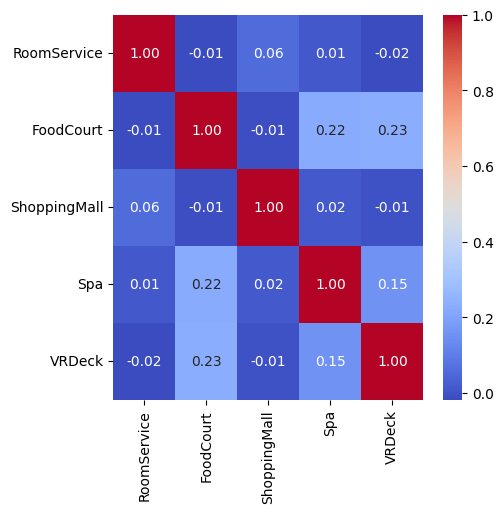

In [308]:
# plot correlation matrix of ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
corr_matrix = data[cols_with_missing].corr(numeric_only=True)
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

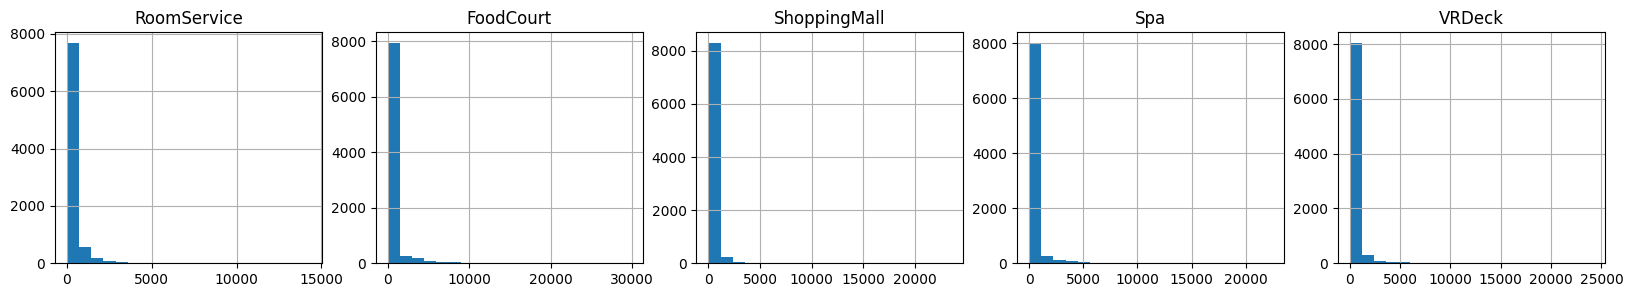

In [309]:
# plot the distribution of the 5 columns
plt.figure(figsize=(20, 3))
for i, col in enumerate(cols_with_missing):
    plt.subplot(1, 5, i+1)
    data[col].hist(bins=20)
    plt.title(col)

In [310]:
data[cols_with_missing].describe()
# std is really high...

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8580.000000,8580.000000,8581.000000,8575.000000,8567.000000
mean,222.906876,454.339977,171.785573,308.780292,302.648535
std,664.368930,1605.430304,601.581625,1132.710170,1141.855811
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,44.000000,70.000000,24.000000,58.000000,44.000000
max,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [311]:
data.groupby('CryoSleep')[cols_with_missing].mean()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
CryoSleep,,,,,
False,350.146772,713.004316,270.586504,486.092940,475.716165
True,0.000000,0.000000,0.000000,0.000000,0.000000
,218.413953,460.920561,145.995215,277.641509,295.142857


In [312]:
# first mark the missing values rows in a new column
data['missing_any'] = np.where(data[cols_with_missing].isnull().any(axis=1), 1, 0)
test['missing_any'] = np.where(test[cols_with_missing].isnull().any(axis=1), 1, 0)

# then impute missing values in cols_with_missing with mean, but impute separately for CryoSleep = False or when it's ''
# (imputing with median is the same as imputing with 0)
for col in cols_with_missing:
    data.loc[data['CryoSleep'] == '', col] = 0
    test.loc[test['CryoSleep'] == '', col] = 0

    cryo_false = data.loc[data['CryoSleep'] == False]
    cryo_false_mean = cryo_false[col].mean()
    data.loc[data['CryoSleep'] == False, col] = cryo_false_mean
    test.loc[test['CryoSleep'] == False, col] = cryo_false_mean

# create a new column 'TotalAmenities' that sums up the 5 columns
data['TotalAmenities'] = data[cols_with_missing].sum(axis=1)
test['TotalAmenities'] = test[cols_with_missing].sum(axis=1)

In [313]:
# mean total amenities for rows with missing values and rows without missing values
data.groupby('missing_any')['TotalAmenities'].mean()

missing_any
0    1383.764131
1    2197.341491
Name: TotalAmenities, dtype: float64

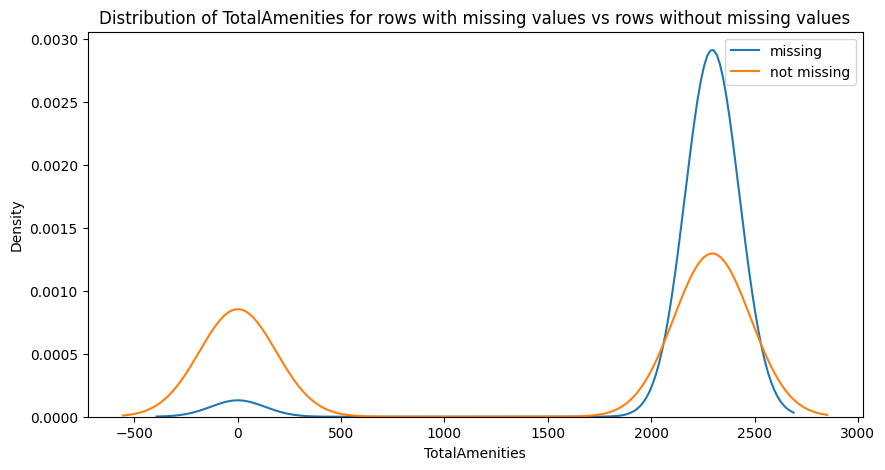

In [314]:
# now compare the distribution of 'TotalAmenities' for rows with missing values and rows without missing values on same plot
plt.figure(figsize=(10, 5))
sns.kdeplot(data.loc[data['missing_any'] == 1, 'TotalAmenities'], label='missing')
sns.kdeplot(data.loc[data['missing_any'] == 0, 'TotalAmenities'], label='not missing')
plt.xlabel('TotalAmenities')
plt.ylabel('Density')
plt.title('Distribution of TotalAmenities for rows with missing values vs rows without missing values')
plt.legend()
plt.show()

In [315]:
# since the two distributions are almost the same, the mean imputation is reasonable and we can drop the 'missing_any' column
data = data.drop('missing_any', axis=1)
test = test.drop('missing_any', axis=1)

# drop TotalAmenities column as well
data = data.drop('TotalAmenities', axis=1)
test = test.drop('TotalAmenities', axis=1)

In [316]:
print(f'% of rows with missing values in data: {len(data[data.isnull().any(axis=1)])/len(data)*100:.2f}%')
print(f'% of rows with missing values in test: {len(test[test.isnull().any(axis=1)])/len(test)*100:.2f}%')

% of rows with missing values in data: 0.00%
% of rows with missing values in test: 0.00%


In [317]:
# save the cleaned data
data.to_csv('data/train_cleaned.csv', index=False)
test.to_csv('data/test_cleaned.csv', index=False)